In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import dataframe_image as dfi
import seaborn as sns 
import numpy as np 

from typing import List, Dict, Any

# ignore warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Models
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC

## Pre-Processing
from sklearn.model_selection import train_test_split, KFold, cross_val_score #train/test split & k-fold cross validation
from sklearn.preprocessing import StandardScaler #scaler
from sklearn.decomposition import PCA #principle component analysis

## Scoring 

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
# Game Outcome Predictors 
classification_df = pd.read_csv("../data/full_csv.csv") # model-ready data 
teams_df = pd.read_csv("../data/categorical_teams_set.csv") # output 

x = classification_df.loc[:, classification_df.columns != 'outcome']
y = classification_df['outcome']

# Creating the Train and Test Split

# Use a train and test split for initial training & testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# Length of Values

pd.DataFrame({
    "x_train count": len(x_train),
    "x_test count":len(x_test),
    "y_train count":len(y_train), 
    "y_test count":len(y_test)
},index=[0]).melt()

,variable,value
0,x_train count,918
1,x_test count,394
2,y_train count,918
3,y_test count,394


In [3]:
# Building, Training, and Testing the Model Stack
## Building each model with some fun inheritance! 

class model_development: 
    
    def __init__(self, model, predictors, target): 
        self.model = model
        self.predictors = predictors
        self.target = target 
    
    def ensemble(names: List[str], models: List) -> Dict[str, Any]: 
        """ Creates a dictionary with each model name and the model associated """
        models = {names[i]: models[i] for i in range(len(names))}
        return models
    
    def evaluate_ensemble(models, x_train, y_train, x_test) -> Dict[str, Any]:
        """ 
        1) Conducts PCA for feature selection and k-fold cross-validation on each model 
        2) Evaluates each model with accuracy, precision, and recall scores and returns all average scores 
        """

        pca = PCA(n_components=10)
        pca.fit_transform(x_train, y_train)
        
        cv = KFold(n_splits=5, random_state=0, shuffle=True)
            
        scores = {
            names: 
                {
                    'Accuracy': cross_val_score(models, x_train, y_train, scoring='accuracy', cv=cv).mean(), 
                    'Precision': cross_val_score(models, x_train, y_train, scoring='precision', cv=cv).mean(), 
                    'Recall': cross_val_score(models, x_train, y_train, scoring='recall', cv=cv).mean()   
                }
             for (names, models) in models.items()
        }

        return scores
    
    def predict(model, x_test): 
        predictions = model.predict(x_test)
        return predictions
    
    def stacking_model(
        estimators: List[Any],
        final_estimator, 
        x_train,
        y_train,
        x_test,
        y_test,
        n_folds):
    
        global cv 
        cv = KFold(n_splits=n_folds, random_state=0, shuffle=True)

        stack = StackingClassifier(
            estimators, final_estimator

        )
        stack = stack.fit(x_train, y_train)
        
        return stack

## Pass in the models we wish to stack 

models = model_development.ensemble(
    names =  ['logit', 'kernel_svm', 'decision_tree'],
    models =  [
        LogisticRegression(),
        SVC(kernel='rbf', gamma=0.05),
        DecisionTreeClassifier()
    ]
)
models_list = list(models.items())

In [4]:
## Process, Train, Evaluate

summary = model_development.evaluate_ensemble(models, x_train, y_train, x_test)
summary = pd.DataFrame.from_records(summary)
summary


,decision_tree,kernel_svm,logit
Accuracy,1.0,0.572969,0.838946
Precision,1.0,0.703490,0.847402
Recall,1.0,0.172146,0.798717


In [5]:
# Training and Implementing the Stacking Model
# Train and implement stacking model 

stacked_model = model_development.stacking_model(
        models_list,
        (make_pipeline(StandardScaler(), LinearSVC(random_state=42))), 
        x_train,
        y_train, 
        x_test,
        y_test,
        n_folds = 10 
)
summary['stacked_linear_svm'] = [
            cross_val_score(stacked_model, x_train, y_train, scoring='accuracy', cv=cv).mean(),
            cross_val_score(stacked_model, x_train, y_train, scoring='precision', cv=cv).mean(),
            cross_val_score(stacked_model, x_train, y_train, scoring='recall', cv=cv).mean()
]
dfi.export(summary, '../images/model_performance.png')
summary

[0613/163741.676828:INFO:headless_shell.cc(660)] Written to file /tmp/tmpjh1e3bpb/temp.png.


,decision_tree,kernel_svm,logit,stacked_linear_svm
Accuracy,1.0,0.572969,0.838946,1.0
Precision,1.0,0.703490,0.847402,1.0
Recall,1.0,0.172146,0.798717,1.0


In [6]:
# Generating Predictions from the Stacked Model
# Predictions will favor the away team (1: Win, 0: Loss)

teams_df['predictions'] = model_development.predict(stacked_model, x)


pd.DataFrame({
    'Predicted': teams_df.predictions.value_counts(),
    'Actual': teams_df.outcome.value_counts()
})


,Predicted,Actual
0,704,704
1,608,608


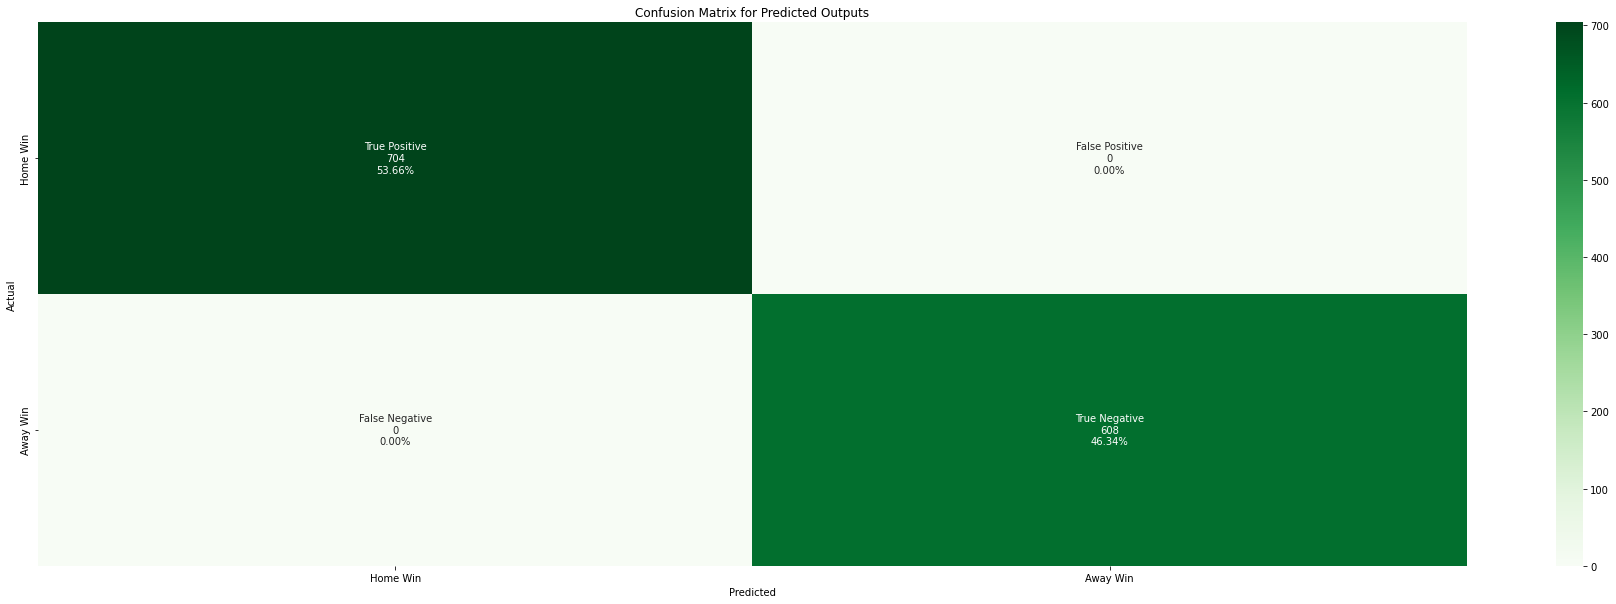

In [7]:
# Assessing Output Predictions
"""
Per the classification of the categorical game outcome, predictions are: 
- _*Home Win*_ : 0
- _*Away Win*_ : 1

The confusion matrix will show the: 
- True Positives
- False Positives
- True Negatives
- False Negatives
"""

conf_matrix = confusion_matrix(teams_df['outcome'], teams_df['predictions'])

plt.figure(figsize=(32,10))

group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
percentage = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{i}\n{j}\n{k}" for i, j, k in zip(group_names, counts, percentage)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_matrix, annot=labels, cmap='Greens', fmt='')
ax.set_title('Confusion Matrix for Predicted Outputs')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Home Win', 'Away Win'])
ax.yaxis.set_ticklabels(['Home Win', 'Away Win'])

plt.savefig('../images/confusion_matrix.png')


# Evaluation

In summary, the models trained especially well with test data and similar results yield from training them on the original data. 
The stacked Linear SVM algorithm on top of the Logistic Regression and Non-Linear/RBF Kernel SVM classifiers settled with favorable precision and accuracy, while not missing too many predictions versus actual values from the original data as we recall. This indicates generating some future game matchups with provided statistics will give us a pretty good idea of who might win at a probable outcome. 

>For insight, we can compare this in a tabular format:


In [8]:
preds_df = teams_df[['date', 'away_team', 'home_team', 'predictions', 'outcome', 'home_wins']].rename(columns={'outcome': 'away_result', 'home_wins': 'home_result'})
preds_df.predictions = preds_df.predictions.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.home_result = preds_df.home_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.away_result = preds_df.away_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df

,date,away_team,home_team,predictions,away_result,home_result
0,2021-10-12,Pittsburgh Penguins,Tampa Bay Lightning,Win,Win,Loss
1,2021-10-14,Pittsburgh Penguins,Florida Panthers,Loss,Loss,Win
2,2021-11-09,Pittsburgh Penguins,Chicago Blackhawks,Loss,Loss,Win
3,2021-11-13,Pittsburgh Penguins,Ottawa Senators,Loss,Loss,Win
4,2021-11-14,Pittsburgh Penguins,Washington Capitals,Loss,Loss,Win
...,...,...,...,...,...,...
1307,2022-04-14,New Jersey Devils,Colorado Avalanche,Loss,Loss,Win
1308,2022-04-16,New Jersey Devils,Seattle Kraken,Loss,Loss,Win
1309,2022-04-18,New Jersey Devils,Vegas Golden Knights,Win,Win,Loss
1310,2022-04-26,New Jersey Devils,Ottawa Senators,Loss,Loss,Win


Given the predictions favor an away win, this can predict if the away team will win a game or not. This is because we can use an _unbiased_ prediction without home field advantage. 

... For fun, I'm an Avs fan. Let's see how that panned out 

In [9]:
def evaluate_predictions(subset: pd.DataFrame(), correct: int, incorrect: int):

    try :
        print(f"{len(correct/incorrect * 100)} accurate.")
    except ZeroDivisionError as e:
         print(f"{e}: no incorrect predictions on subset.")

    return
      
avs_away_games = preds_df[preds_df['away_team']=='Colorado Avalanche']
avscorrect = len(avs_away_games[avs_away_games.predictions == avs_away_games.away_result]) # accurate predictions
avsincorrect = len(avs_away_games[avs_away_games.predictions != avs_away_games.away_result]) # innaccurate predictions

avs_home_games = preds_df[preds_df['home_team']=='Colorado Avalanche']
avs_home_correct = len(avs_home_games[avs_home_games.predictions == avs_home_games.away_result]) # accurate predictions
avs_home_incorrect = len(avs_home_games[avs_home_games.predictions != avs_home_games.away_result]) # innaccurate predictions

correct = len(preds_df[preds_df.predictions == preds_df.away_result]) # accurate predictions
incorrect = len(preds_df[preds_df.predictions != preds_df.away_result]) # innaccurate predictions


In [10]:
# Avalanche Away Games 

evaluate_predictions(avs_away_games, avscorrect, avsincorrect)

division by zero: no incorrect predictions on subset.


In [11]:
# Avalanche Home Games 

evaluate_predictions(avs_home_games, avs_home_correct, avs_home_incorrect)

division by zero: no incorrect predictions on subset.


In [12]:
# Original Data 

evaluate_predictions(preds_df, correct, incorrect)

division by zero: no incorrect predictions on subset.


## Summary

The model is extremely accurate after adding in a decision tree classifier prior to stacking with the super-learner SVM. The assessment of the model determines that every prediction is an exact match of the original data, indicating it performs flawlessly upon the data for which it was trained. We can take a look at the Avalanche Vs. Lightning matchup to best understand how the algorithm may have performed in their past games, then test the capability of the model to predict new input data by using this year's Stanley Cup Final schedule among the Avalanche and Lightning. 

In [13]:
avs_vs_lightning_away = preds_df[(preds_df['away_team']=='Colorado Avalanche') & (preds_df['home_team']=='Tampa Bay Lightning')]
avs_vs_lightning_home = preds_df[(preds_df['away_team']=='Tampa Bay Lightning') & (preds_df['home_team']=='Colorado Avalanche')]
result = [avs_vs_lightning_away, avs_vs_lightning_home]
result = pd.concat(result)
result

,date,away_team,home_team,predictions,away_result,home_result
945,2021-10-23,Colorado Avalanche,Tampa Bay Lightning,Win,Win,Loss
391,2022-02-10,Tampa Bay Lightning,Colorado Avalanche,Loss,Loss,Win


Based upon prior data, the Colorado Avalanche have defeated their Stanley Cup Final opponents the Tampa Bay Lightning during the regular season at home and away. We can simulate the Stanley Cup Final with the orientation it is scheduled: 

- Game 1 
- Game 2
- Game 3 
- Game 4
- Game 5
- Game 6
- Game 7